<a href="https://colab.research.google.com/github/angelinux/covid19-italy/blob/master/Epidemic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
!git clone https://github.com/pcm-dpc/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 333 (delta 5), reused 17 (delta 4), pack-reused 303
Receiving objects: 100% (333/333), 17.89 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [0]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [0]:
df = pd.read_csv('COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])
df_sum = df.groupby(by='data').sum()

In [74]:
df_sum.columns

Index(['codice_regione', 'lat', 'long', 'ricoverati_con_sintomi',
       'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
      dtype='object')

In [0]:
N = 60500000
df_sum['S'] = N-df_sum['totale_casi']
df_sum['I'] = df_sum['totale_attualmente_positivi']
df_sum['R'] = df_sum['dimessi_guariti']
df_sum['D'] = df_sum['deceduti']

In [0]:
def func(y, t, N, beta, gamma, gamma_d):
    # S, I, R values assigned from vector
    S, I, R, D = y
    # differential equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - gamma_d * I
    dRdt = gamma * I
    dDdt = gamma_d * I
    return dSdt, dIdt, dRdt, dDdt

In [81]:
df_sum['beta'] = (df_sum['S'].shift(1).fillna(N)-df_sum['S'])/(df_sum['S']*df_sum['I'])*N
df_sum['gamma'] = (df_sum['R'] - df_sum['R'].shift(1).fillna(1))/df_sum['I']
df_sum['gamma_d'] = (df_sum['D'] - df_sum['D'].shift(1).fillna(1))/df_sum['I']
df_sum[['beta','gamma', 'gamma_d']].iloc[2:].describe()

,beta,gamma,gamma_d
count,13.000000,13.000000,13.000000
mean,0.250136,0.022074,0.009730
std,0.069362,0.020998,0.004557
min,0.186382,0.001218,0.003171
25%,0.205930,0.005167,0.007113
50%,0.228794,0.013041,0.009809
75%,0.246418,0.035967,0.012148
max,0.425175,0.071429,0.020824


In [0]:
first_point = 6 # 2020-03-01

@ticker.FuncFormatter
def major_formatter(x, pos):
  d = datetime(2020, 3, 1)
  d += timedelta(days=int(x))
  return d.strftime('%Y-%m-%d')

# initial infected
I0 = df_sum.iloc[first_point]['I']
# initial recovered
R0 = df_sum.iloc[first_point]['R']
# initial dead
D0 = df_sum.iloc[first_point]['D']
#initial susceptible
S0 = N - I0 - R0 - D0

# num days
n_days = 90

# contact rate
beta = 0.237
# mean recovery rate
gamma = 0.025
# mean dead rate
gamma_d = 0.012

# initial conditions vector
y0 = S0, I0, R0, D0
# 200 evenly spaced values (representing days)
t = np.linspace(0, n_days, n_days)
# Integrate the diff eqs over the time array
values = odeint(func, y0, t, args=(N, beta, gamma, gamma_d))
# assign S, I, R values from values transpose
S, I, R, D = values.T


points = df_sum.iloc[first_point:]['I'].values
points2 = df_sum.iloc[first_point:]['R'].values
points3 = df_sum.iloc[first_point:]['D'].values

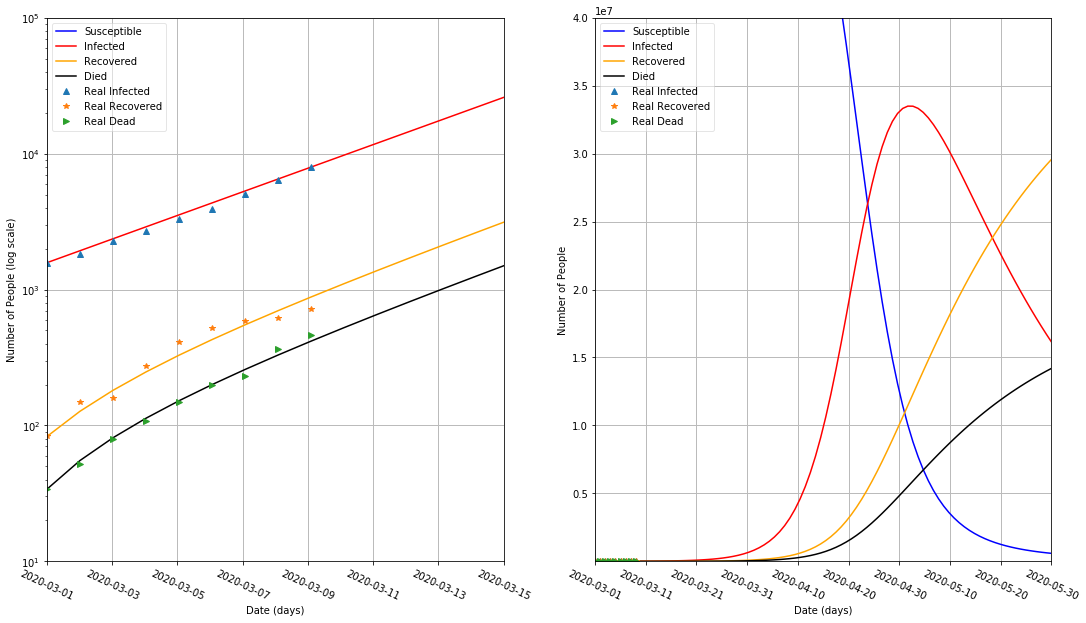

In [131]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(121, axisbelow=True)
ax.plot(t, S, 'blue', lw=1.5, label='Susceptible')
ax.plot(t, I, 'red', lw=1.5, label='Infected')
ax.plot(t, R, 'orange', lw=1.5, label='Recovered')
ax.plot(t, D, 'black', lw=1.5, label='Died')
ax.plot(t[:len(points)], points, '^', label='Real Infected')
ax.plot(t[:len(points2)], points2, '*', label='Real Recovered')
ax.plot(t[:len(points3)], points3, '>', label='Real Dead')
ax.set_xlabel('Date (days)')
ax.set_ylabel('Number of People (log scale)')
ax.set_yscale('log')
ax.set_ylim(10,100000)
ax.set_xlim(0,14)
ax.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='x', labelrotation=-25)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)


ax = fig.add_subplot(122, axisbelow=True)
ax.plot(t, S, 'blue', lw=1.5, label='Susceptible')
ax.plot(t, I, 'red', lw=1.5, label='Infected')
ax.plot(t, R, 'orange', lw=1.5, label='Recovered')
ax.plot(t, D, 'black', lw=1.5, label='Died')
ax.plot(t[:len(points)], points, '^', label='Real Infected')
ax.plot(t[:len(points2)], points2, '*', label='Real Recovered')
ax.plot(t[:len(points3)], points3, '>', label='Real Dead')
ax.set_xlabel('Date (days)')
ax.set_ylabel('Number of People')
#ax.set_yscale('log')
ax.set_ylim(1,40000000)
ax.set_xlim(0,90)
ax.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='x', labelrotation=-25)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

plt.savefig('covid19-epidemy.png')

plt.show()
